In [269]:
import os
import sys
from pathlib import Path
from dotenv import load_dotenv

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
env_path = Path(project_root) / ".env"
if env_path.exists():
    load_dotenv(dotenv_path=env_path)
else:
    load_dotenv()

DATA_DIR = Path().resolve().parent / "data"

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [270]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from copy import deepcopy

from fredapi import Fred
from stargazer.stargazer import Stargazer

# 1. Data Processing

In [271]:
# Some utils for data processing
def qdate_to_quarter(qdate_series):
    return (
        pd.PeriodIndex(qdate_series, freq='Q')
        .to_timestamp(how = 'end')
    )


def get_stats(res):
    return pd.Series({
        "coef": res.params['dFF_x_Bank_HHI'],
        "std_err": res.std_errors['dFF_x_Bank_HHI'],
        "t": res.tstats['dFF_x_Bank_HHI'],
        "pval": res.pvalues['dFF_x_Bank_HHI']
    }, name = 'dFF_x_Bank_HHI')


## (a) Read data 

In [272]:
pdf_data = pd.read_stata(
    DATA_DIR / "callreports_1976_2020_WRDS.dta"/ "callreports_1976_2020_WRDS.dta",
    # preserve_dtypes = False
    convert_dates = True,
    preserve_dtypes = False
)
pdf_data = pdf_data.dropna(subset=['cert', 'dateq'])
pdf_data['cert'] = pdf_data['cert'].astype('int64')
pdf_data['dateq'] = qdate_to_quarter(pdf_data['dateq'])
pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')
# pdf_data['dateq'] = qdate_to_date(pdf_data)
# pdf_data['dateq'] = pd.to_datetime(pdf_data['dateq'], format='ISO8601')
# pdf_data['date'] = pd.to_datetime(pdf_data['date'], format='ISO8601')

In [273]:
pdf_data.head(1)

,rssdid,chartertype,cert,bhcid,date,name,assets,reloans,cash,persloans,...,intincnet,nonintexp,nonintinc,operinc,salaries,domdepservicecharges,tradingrevenue,intincreloans1to4fam,intexptimedeple250k,intexptimedepge250k
0,28.0,200.0,26606,0.0,1986-03-31,FIRST ATLANTIC BK,2779.0,0.0,1395.0,23.0,...,21.0,52.0,0.0,22.0,26.0,0.0,NaN,NaN,NaN,NaN


## (b). Merge with the Bank Herfindahl

In [274]:
# pdf_herf = pd.read_csv(
#     DATA_DIR / "l1_herfdepcty.csv"
# )
# pdf_herf = pdf_herf.dropna()
# pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
# pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])

In [275]:
pdf_herf = pd.read_stata(
    DATA_DIR / "l1_herfdepcty.dta",
    convert_dates= True,
    preserve_dtypes= False
)
pdf_herf = pdf_herf.dropna()
pdf_herf['cert'] = pdf_herf['cert'].astype('int64')
pdf_herf['dateq'] = qdate_to_quarter(pdf_herf['dateq'])


In [276]:
pdf_herf.head(2)

,cert,dateq,l1_herfdepcty
39,8,1994-09-30 23:59:59.999999999,0.317719
40,8,1994-12-31 23:59:59.999999999,0.317719


In [277]:
pdf_merged = pdf_data.merge(
    pdf_herf,
    on=["cert", "dateq"],
    how="inner",
    suffixes=("", "_herf")
)
pdf_merged.sort_values(['cert','dateq'], inplace=True)
temp_duplicate_certs = (pdf_merged[['cert','dateq', 'date']].groupby(['date', 'cert'])['date'].count() >1)
duplicate_certs = temp_duplicate_certs[temp_duplicate_certs].index.get_level_values('cert').drop_duplicates()
pdf_merged = pdf_merged[~pdf_merged['cert'].isin(duplicate_certs)]

## (c) download Fed Funds rate from FRED and merge

Transformation done here: 
* Aggregate to quarterly values by taking the latest fed funds rate for each quarter. 
* Construct the change in fedfunds rate $\Delta FF_t = FF_{t+1} - FF_{t}$ and $FF_t$ is aggregated to quarterly frequency from monthly observations by averaging the observations.


In [278]:
# Fetch FRED data
fread = Fred(api_key = os.getenv("API_KEY_FRED"))
pds_ffs = fread.get_series("FEDFUNDS")
pds_ffs.name = "fedfunds"
pds_ffs.index.name = "date"
pdf_ffs = pds_ffs.to_frame().reset_index()
pdf_ffs['date'] = pd.to_datetime(pdf_ffs['date'], format='YYYY-MM-DD')
pdf_ffs['dateq'] = qdate_to_quarter(pdf_ffs['date'])


In [279]:
# Filter to quarterly frequency 
# check the paper: 
pdf_ffsq = (
    pdf_ffs.sort_values('date')
    .groupby('dateq', as_index=False)['fedfunds']
    .mean()
)
pdf_ffsq['fedfunds'] = pdf_ffsq['fedfunds'].div(100)
pdf_ffsq['d_fedfunds'] = pdf_ffsq['fedfunds'].diff().shift(-1) # dFF_t = FF_{t+1} - FF_t


In [280]:
pdf_ffsq

,dateq,fedfunds,d_fedfunds
0,1954-09-30 23:59:59.999999999,0.010300,-0.000433
1,1954-12-31 23:59:59.999999999,0.009867,0.003567
2,1955-03-31 23:59:59.999999999,0.013433,0.001567
3,1955-06-30 23:59:59.999999999,0.015000,0.004400
4,1955-09-30 23:59:59.999999999,0.019400,0.004167
...,...,...,...
281,2024-12-31 23:59:59.999999999,0.046500,-0.003200
282,2025-03-31 23:59:59.999999999,0.043300,0.000000
283,2025-06-30 23:59:59.999999999,0.043300,-0.000367
284,2025-09-30 23:59:59.999999999,0.042933,-0.003083


In [281]:
pdf_merged = pdf_merged.merge(
    pdf_ffsq,
    on=["dateq"],
    how="inner"
)

## (d) Construct Table 8 variables



Apply filters

In [285]:
# Filter some values
# (1) Remove zero problems with log diffs
# (2) Remove one oulier 1996-03-31 cert 33260 that has deposits 15, dep interest 3403.0 (huge dep rate)
# (3) TODO: Remove banks with non-complete observation history
# (4) Only keep chartertype 200

# nonneg_cols = ['deposits']#,'totsavdep', 'timedep','liabilities','assets','cash','securities','loans']
# nonneg_mask = [np.greater(pdf_merged[col], 0) for col in nonneg_cols]
# pdf_merged = pdf_merged[np.all(np.array(nonneg_mask).T, axis = 1)]
dateq_diff = pdf_merged['dateq'].drop_duplicates().diff().max()
history_flag = (
    pdf_merged
    .groupby('cert')['dateq']
    .transform(
        lambda x: (x.sort_values().diff() > dateq_diff).any()
        )
    )
pdf_merged['flag_incomplete_hist'] = history_flag

pdf_merged = pdf_merged[~pdf_merged['flag_incomplete_hist']]
pdf_merged = pdf_merged[pdf_merged['chartertype'] == 200]
pdf_merged = pdf_merged[
    ~((pdf_merged['dateq'] == pd.to_datetime("1996-03-31 23:59:59.999999999")) 
    &(pdf_merged['cert'] == 33260))]

In [287]:
dateq_diff = pdf_merged['dateq'].drop_duplicates().diff().max()
history_flag = (
    pdf_merged
    .groupby('cert')['dateq']
    .transform(
        lambda x: (x.diff() > dateq_diff).any()
        )
    )
 

In [288]:
history_flag.sum()

np.int64(0)

In [289]:
dateq_diff

Timedelta('92 days 00:00:00')

The following variables are constructed
* Deposit spread, calculated with average deposits, produces similar standard erros as with paper
* All $\Delta Y_{it}$ are calculated as $\Delta Y_{it} = Y_{i, t+1} - Y_{i, t}$ to follow the conventions in the paper. 
* $\dots$

In [290]:
# log change in domestic deposits
def groupbed_log_diff(pdf, value_col, group_col = 'cert'):
    return np.log(pdf[value_col] / (pdf.groupby(group_col)[value_col].shift(1))).shift(-1)

# Panel A dep-vals (bank liabilities)
pdf_merged['d_total_deposits_A'] = groupbed_log_diff(pdf_merged, 'deposits')
pdf_merged['d_savings_deposits_A'] = groupbed_log_diff(pdf_merged, 'totsavdep')
pdf_merged['d_time_deposits_A'] = groupbed_log_diff(pdf_merged, 'timedep') # check
pdf_merged['wholesale_funding'] = pdf_merged['liabilities'] - pdf_merged['deposits'] # check subtrackt foreign deposits
# pdf_merged["wholesale_funding"] = (
#     pdf_merged["fed_funds_purchased"]     # RCONB993
#     + pdf_merged["repos_sold"]            # RCONB995
#     + pdf_merged["other_borrowed_money"]  # RCON2800
#     + pdf_merged["subordinated_debt"]     # RCON3548
# )
pdf_merged['d_wholesale_funding_A'] = groupbed_log_diff(pdf_merged, 'wholesale_funding')
pdf_merged['d_liabilities_A'] = groupbed_log_diff(pdf_merged, 'liabilities')

# Panel B dep-vals (bank assets)
pdf_merged['d_total_assets_B'] = groupbed_log_diff(pdf_merged, 'assets')
pdf_merged['d_cash_B'] = groupbed_log_diff(pdf_merged, 'cash')
pdf_merged['d_securities_B'] = groupbed_log_diff(pdf_merged, 'securities')
pdf_merged['d_total_loans_B'] = groupbed_log_diff(pdf_merged, 'loans')
pdf_merged['d_real_estate_loans_B'] = groupbed_log_diff(pdf_merged, 'reloans') # check that has values
pdf_merged['d_ciloans_B'] = groupbed_log_diff(pdf_merged, 'ciloans')

c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\palmunen\PR\git\financial_econometrics_II\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc

In [291]:
# Total domestic deposits		deposits	RCON2200	197603-
# Interest expense on domestic deposits	Yes	intexpdomdep	intexpalldep-intexpfordep	198303-	Interest expense on domestic deposits can be calculated as total interest expense on deposits minus interest expense on foreign deposits 


In [292]:
# Deposit spread based on annualized (x 4) domestic deposits and domestic expenses, 
# even thouth the annualization is not needed for regrs
# avg deposits produce matching values with the paper
pdf_merged['deposits_lag'] = pdf_merged.groupby(['cert'])['deposits'].shift(1)
pdf_merged['avg_deposits'] = (pdf_merged['deposits'] + pdf_merged['deposits_lag']).div(2)
pdf_merged['dep_rate'] = 4 * pdf_merged['intexpdomdep'] / pdf_merged['avg_deposits']
pdf_merged['deposit_spread'] = pdf_merged['fedfunds'] - pdf_merged['dep_rate']
pdf_merged['d_deposit_spread_A'] = pdf_merged.groupby('cert')['deposit_spread'].diff().shift(-1)
# pdf_merged.dropna(inplace = True, subset=['d_deposit_spread_A'])

In [293]:
pdf_merged[['cert', 'dateq', 'intexpdomdep', 'deposits', 'deposits_lag', 'avg_deposits', 'dep_rate', 'fedfunds', 'deposit_spread', 'd_fedfunds', 'd_deposit_spread_A']]

,cert,dateq,intexpdomdep,deposits,deposits_lag,avg_deposits,dep_rate,fedfunds,deposit_spread,d_fedfunds,d_deposit_spread_A
0,8,1994-09-30 23:59:59.999999999,13970.0,2191522.0,NaN,NaN,NaN,0.044867,NaN,0.006800,NaN
1,8,1994-12-31 23:59:59.999999999,15539.0,2202188.0,2191522.0,2196855.0,0.028293,0.051667,0.023373,0.006433,0.004063
2,8,1995-03-31 23:59:59.999999999,16218.0,2028977.0,2202188.0,2115582.5,0.030664,0.058100,0.027436,0.002100,-0.002000
3,8,1995-06-30 23:59:59.999999999,17348.0,1963258.0,2028977.0,1996117.5,0.034763,0.060200,0.025437,-0.002233,-0.000820
4,8,1995-09-30 23:59:59.999999999,16161.0,1913449.0,1963258.0,1938353.5,0.033350,0.057967,0.024617,-0.000767,-0.000807
...,...,...,...,...,...,...,...,...,...,...,...
584487,91393,1996-06-30 23:59:59.999999999,211.0,77173.0,77231.0,77202.0,0.010932,0.052433,0.041501,0.000633,0.001580
584488,91393,1996-09-30 23:59:59.999999999,191.0,75840.0,77173.0,76506.5,0.009986,0.053067,0.043081,-0.000267,0.000527
584489,91393,1996-12-31 23:59:59.999999999,177.0,78195.0,75840.0,77017.5,0.009193,0.052800,0.043607,-0.000033,-0.030986
584490,91393,1997-03-31 23:59:59.999999999,734.0,68073.0,78195.0,73134.0,0.040145,0.052767,0.012621,0.002467,0.002329


In [294]:
# Fixed effects related, mentioned in the footnote
pdf_merged["post_2008"] = (pdf_merged["dateq"] >= pd.to_datetime("2009-01-01")).astype(int)
pdf_merged["fe_bank_post2008"] = pdf_merged["cert"].astype(str) + "_" + pdf_merged["post_2008"].astype(str)

# 2. Fit Regression Models

In [295]:
pdf_regr = deepcopy(pdf_merged)
pdf_regr['bank_hhi'] = pdf_regr['l1_herfdepcty']
pdf_regr['dFF_x_Bank_HHI'] = pdf_regr['d_fedfunds'] * pdf_regr['bank_hhi']
pdf_regr.set_index(['cert', 'dateq'], inplace=True)

## d) Run the regressions

In [296]:
# Dependent variables table A 
all_vars = pdf_regr.columns
depvars_a = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_A')].tolist()
depvars_b = pdf_regr.columns[all_vars.str.startswith('d_') & all_vars.str.endswith('_B')].tolist()
depvars = depvars_a + depvars_b

In [297]:
def table8_reg(df, depvar, entity_effects = False, time_effects = True, other_effects = ["fe_bank_post2008"], model = False):

    mask = df[depvar].notnull() & np.isfinite(df[depvar])
    df = df.loc[mask]
    y = df[depvar]
    X = df[["dFF_x_Bank_HHI", "bank_hhi"]]
    
    mod = PanelOLS(
        y,
        X,
        entity_effects=entity_effects,        
        time_effects=time_effects,
        other_effects= None if other_effects is None else df[other_effects]
    )


    clusters = pd.Series(
        df.index.get_level_values("cert"), 
        index=df.index, name="cert"
    )

    res = mod.fit(
        cov_type="clustered",
        clusters=clusters
    )

    return res

In [298]:
res_panel8 = {dep_val: table8_reg(pdf_regr, dep_val, model=True) for dep_val in depvars}

In [299]:
for name, res in res_panel8.items():
    print(f"\n=== Regression: {name} ===\n")
    # Try to print the neatly formatted summary
    try:
        print(res.summary)
    except Exception:
        # Fallback to str(res)
        print(res)



=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     8.088e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0137
No. Observations:              570963   R-squared (Within):               0.0003
Date:                Thu, Dec 11 2025   R-squared (Overall):             -0.0022
Time:                        20:49:00   Log-likelihood                 4.305e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      22.341
Entities:                       11657   P-value                           0.0000
Avg Obs:                       48.980   Distribution:                F(2,552391)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

In [300]:
def create_regression_table(results_dict, depvars=None):
    """Create a summary DataFrame from panel regression results."""
    if depvars is None:
        depvars = list(results_dict.keys())
    
    rows = []
    for var in depvars:
        res = results_dict[var]
        rows.append({
            'Dependent Variable': var,
            'Coefficient': res.params['dFF_x_Bank_HHI'],
            'Std. Error': res.std_errors['dFF_x_Bank_HHI'],
            't-stat': res.tstats['dFF_x_Bank_HHI'],
            'p-value': res.pvalues['dFF_x_Bank_HHI'],
            'R-squared': res.rsquared
        })
    pdf = pd.DataFrame(rows)
    pdf = pdf.set_index('Dependent Variable').T
    col_names = {col: f"\\makecell{{{col.replace('_', ' \\\\')}}}" for col in depvars}
    pdf = pdf.rename(columns=col_names)
    return pdf

In [301]:
table8_a = create_regression_table(res_panel8, depvars=depvars_a)
table8_b = create_regression_table(res_panel8, depvars=depvars_b)

In [302]:
table8_a.columns = pd.MultiIndex.from_product([['Panel A'], table8_a.columns])
table8_b.columns = pd.MultiIndex.from_product([['Panel B'], table8_b.columns])


In [303]:
print(table8_a.to_latex(escape=False))

\begin{tabular}{lrrrrrr}
\toprule
 & \multicolumn{6}{r}{Panel A} \\
Dependent Variable & \makecell{d \\total \\deposits \\A} & \makecell{d \\savings \\deposits \\A} & \makecell{d \\time \\deposits \\A} & \makecell{d \\wholesale \\funding \\A} & \makecell{d \\liabilities \\A} & \makecell{d \\deposit \\spread \\A} \\
\midrule
Coefficient & -1.723549 & -1.320159 & -3.095140 & 3.513942 & -1.233168 & 0.067058 \\
Std. Error & 0.264973 & 0.299869 & 0.327712 & 1.131627 & 0.250154 & 0.014562 \\
t-stat & -6.504628 & -4.402452 & -9.444694 & 3.105212 & -4.929633 & 4.605149 \\
p-value & 0.000000 & 0.000011 & 0.000000 & 0.001902 & 0.000001 & 0.000004 \\
R-squared & 0.000081 & 0.000035 & 0.000213 & 0.000013 & 0.000077 & 0.000039 \\
\bottomrule
\end{tabular}



## e) The role of fixed effects 
Iterate through all the combinations, {(firm effects), (time effects), (firm effects * 2008_ind), (firm effects, time effects)}

In [304]:
kwargs_to_iterate = {
    'entity': {'entity_effects': True, 'time_effects': False, 'other_effects': None},
    'time': {'entity_effects': False, 'time_effects': True, 'other_effects': None},
    'timeX2008': {'entity_effects': False, 'time_effects': False, 'other_effects': ["fe_bank_post2008"]},
    'entityXtime': {'entity_effects': True, 'time_effects': True, 'other_effects': None},
    'entityXtimeX2008': {'entity_effects': False, 'time_effects': True, 'other_effects': ["fe_bank_post2008"]}, # the base case with all specified fixed effecs
}

In [305]:
fe_results = {}
for key, kwargs in kwargs_to_iterate.items():
    res_panel = {dep_val: get_stats(table8_reg(pdf_regr, dep_val, **kwargs)) for dep_val in depvars}
    fe_results[key] = pd.DataFrame(res_panel)


In [306]:
fe_results_summary = []
for depvar in fe_results['entity'].columns:
    print(f"\n{'='*80}")
    print(f"Dependent Variable: {depvar}")
    print(f"{'='*80}\n")
    
    results_for_depvar = pd.DataFrame({
        fe_spec: fe_results[fe_spec][depvar] 
        for fe_spec in fe_results.keys()
    })
    results_for_depvar.index.name = 'val'
    results_for_depvar['var'] = depvar
    results_for_depvar = results_for_depvar.reset_index()
    fe_results_summary.append(results_for_depvar)
    print(results_for_depvar.to_string())



Dependent Variable: d_total_deposits_A

       val     entity      time  timeX2008  entityXtime  entityXtimeX2008                 var
0     coef  -1.824988 -0.583979  -1.190970    -0.986857     -1.723549e+00  d_total_deposits_A
1  std_err   0.124913  0.265122   0.125969     0.263181      2.649728e-01  d_total_deposits_A
2        t -14.610083 -2.202682  -9.454494    -3.749734     -6.504628e+00  d_total_deposits_A
3     pval   0.000000  0.027618   0.000000     0.000177      7.795187e-11  d_total_deposits_A

Dependent Variable: d_savings_deposits_A

       val     entity      time  timeX2008  entityXtime  entityXtimeX2008                   var
0     coef  -6.916687 -0.355140  -6.712150    -0.745504         -1.320159  d_savings_deposits_A
1  std_err   0.169322  0.302473   0.168905     0.300822          0.299869  d_savings_deposits_A
2        t -40.849296 -1.174122 -39.739296    -2.478223         -4.402452  d_savings_deposits_A
3     pval   0.000000  0.240347   0.000000     0.013204       

In [307]:
# TODO setup a barplot for the coefficients for easy comparison

## f) Robustness Checks

Results upto and including 2007Q4

In [308]:
pdf_regr2008 =pdf_regr.loc[
    pdf_regr.index.get_level_values('dateq') < pd.to_datetime('2008-01-01')
] 
res_panel_robust2008 = {dep_val: table8_reg(
        pdf_regr2008, 
        dep_val
    )
    for dep_val in depvars
}

In [309]:
for name, res in res_panel_robust2008.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     6.309e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0217
No. Observations:              423851   R-squared (Within):               0.0003
Date:                Thu, Dec 11 2025   R-squared (Overall):             -0.0072
Time:                        20:52:27   Log-likelihood                 3.036e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.010
Entities:                       11395   P-value                           0.0000
Avg Obs:                       37.196   Distribution:                F(2,412401)
Min Obs:                       1.0000                                           
Max Obs:                       54.000   F-statistic (robust):       

Analysis with largest 10% of banks

In [310]:
pds_average_assets = pdf_regr.groupby('cert')['assets'].mean()
top_10_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.90)].index
pdf_regr_top10 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_10_cert)
]
res_panel_robust_top10 = {dep_val: table8_reg(
        pdf_regr_top10, dep_val
    )
    for dep_val in depvars
}

In [311]:
for name, res in res_panel_robust_top10.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                     5.581e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0166
No. Observations:               50793   R-squared (Within):            1.691e-05
Date:                Thu, Dec 11 2025   R-squared (Overall):              0.0013
Time:                        20:52:56   Log-likelihood                    7133.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.1368
Entities:                        1159   P-value                           0.8722
Avg Obs:                       43.825   Distribution:                 F(2,49016)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

Analysis with largest 25% of banks

In [312]:
top_25_cert = pds_average_assets[pds_average_assets > np.quantile(pds_average_assets, 0.75)].index
pdf_regr_top25 = pdf_regr.loc[
    pdf_regr.index.get_level_values('cert').isin(top_25_cert)
]
res_panel_robust_top25 = {dep_val: table8_reg(
        pdf_regr_top25, dep_val
    )
    for dep_val in depvars
}

In [313]:
for name, res in res_panel_robust_top25.items():
    print(f"\n=== Regression: {name} ===\n")
    try:
        print(res.summary)
    except Exception as e:
        print(f"Could not display summary for {name}: {e}")


=== Regression: d_total_deposits_A ===

                          PanelOLS Estimation Summary                           
Dep. Variable:     d_total_deposits_A   R-squared:                      9.16e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0638
No. Observations:              136890   R-squared (Within):              -0.0003
Date:                Thu, Dec 11 2025   R-squared (Overall):             -0.0146
Time:                        20:53:00   Log-likelihood                 5.726e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.0612
Entities:                        2912   P-value                           0.0023
Avg Obs:                       47.009   Distribution:                F(2,132322)
Min Obs:                       1.0000                                           
Max Obs:                       77.000   F-statistic (robust):       

# A. Descriptive stats to see that transformations match with the paper

<Axes: xlabel='dateq'>

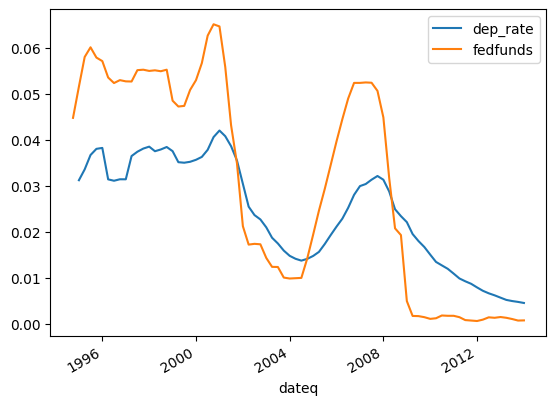

In [314]:
temp_mean = pdf_merged.groupby('dateq')[['dep_rate', 'fedfunds']].mean()
temp_mean.plot()

In [315]:
temp_outlier = pdf_merged[pdf_merged['dateq'] == temp_mean[np.equal(temp_mean['dep_rate'], temp_mean['dep_rate'].max())].index[0]]
temp_outlier[temp_outlier['dep_rate'] == temp_outlier['dep_rate'].max()][['dateq', 'cert']]#.to_clipboard()

,dateq,cert
416717,2000-12-31 23:59:59.999999999,21626
